In [104]:
#extra module installation
#!pip3 install patchify

In [105]:
#imports
import time
from glob import glob 
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Conv2DTranspose,BatchNormalization,Flatten,Dense,Reshape
from tensorflow.keras import activations 
from tensorflow.keras import optimizers 
import cv2
import math
from skimage.metrics import structural_similarity as ssim
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
from patchify import patchify, unpatchify
import random
from prettytable import PrettyTable
from tensorflow.keras.callbacks import ModelCheckpoint 

In [106]:
#global variables
SIGMA=25
EPOCHS=200
LR=1e-3
BATCH_SIZE=128

In [107]:
#link the google drive 
# from google.colab import drive
# drive.mount('/content/drive')

In [108]:
#!unzip /content/drive/MyDrive/notebooks/train.zip

### comparative analysis


In [109]:
#calculate mse between two images
def mse(imageA,imageB):
    mse_error=np.sum((imageA.astype("float")-imageB.astype("float"))**2)
    mse_error /= float(imageA.shape[0] * imageA.shape[1])
    
    #return the MSE . the lower the error, the more 'similar' the two images are
    return np.sqrt(mse_error)

In [110]:
#calculate PSNR between two images
def PSNR(imageA,imageB):
    mse_error=mse(imageA,imageB)
    if mse_error ==0 :
        return 100
    max_pixel=255.0
    #higher the PSNR, better the quality 
    psnr=20*math.log10(max_pixel/np.sqrt(mse_error))
    return psnr

In [111]:
#function to compare the images
def compare_images(imageA,imageB):
    #calculate MSE and SSIM
    m=mse(imageA,imageB)
    p=PSNR(imageA,imageB)
    s=ssim(imageA,imageB)
    
    #higher the SSIM, the more "similar" two images are
    return [m,p,s]

### Load the dataset

In [112]:
training_files=glob('/content/train/original/*')
GT=[]
noisy=[]
noisy_path='/content/train/noisy/'
for file in training_files:
  a=file.split('/')[-1]
  b=noisy_path+a
  GT.append(file)
  noisy.append(b)

df=pd.DataFrame()
df['ground_truth']=GT
df['noisy']=noisy 
print(df.head())
print(df.shape)


                       ground_truth                          noisy
0  /content/train/original/0299.png  /content/train/noisy/0299.png
1  /content/train/original/0367.png  /content/train/noisy/0367.png
2  /content/train/original/0245.png  /content/train/noisy/0245.png
3  /content/train/original/0060.png  /content/train/noisy/0060.png
4  /content/train/original/0279.png  /content/train/noisy/0279.png
(400, 2)


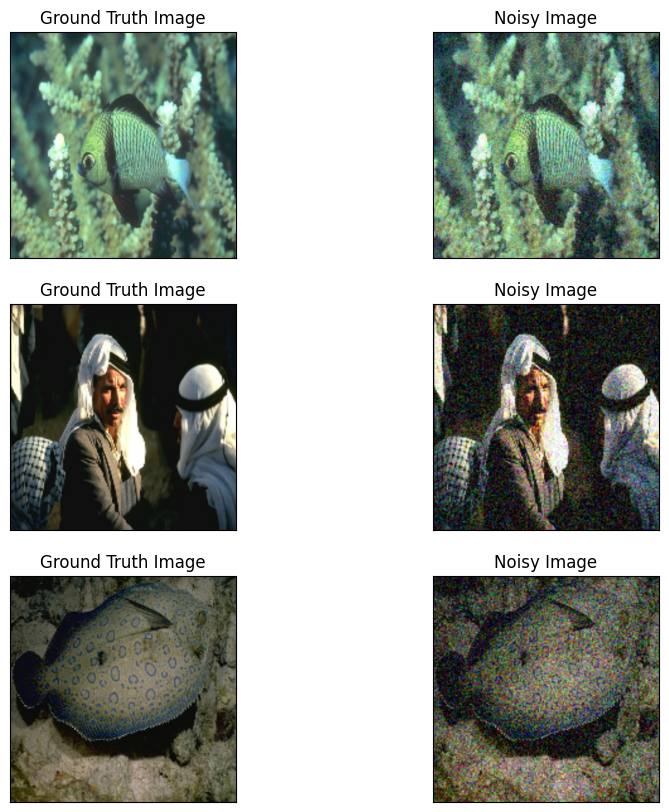

In [113]:
#display few clean-noisy image pairs
sample=df.sample(3)
fig, ax = plt.subplots(len(sample),2,figsize=(10,10))
for i in range(len(sample)):
  img = cv2.imread(sample['ground_truth'].iloc[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(512,512))
  ax[i][0].imshow(img)
  ax[i][0].get_xaxis().set_visible(False)
  ax[i][0].get_yaxis().set_visible(False)
  ax[i][0].title.set_text("Ground Truth Image")
  
  img = cv2.imread(sample['noisy'].iloc[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(512,512))
  ax[i][1].imshow(img)
  ax[i][1].get_xaxis().set_visible(False)
  ax[i][1].get_yaxis().set_visible(False)
  ax[i][1].title.set_text("Noisy Image")

### Splitting the dataset into train and test datasets

In [114]:
X=df['noisy']
Y=df['ground_truth']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

#Storing the image patches as pickle files

pickle.dump((X_train,y_train),open('train_path.pkl','wb'))
pickle.dump((X_test,y_test),open('test_path.pkl','wb'))


X_train, y_train = pickle.load(open('train_path.pkl', 'rb'))
X_test,y_test = pickle.load(open('test_path.pkl', 'rb'))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(320,)
(320,)
(80,)
(80,)


### Create patches from images

In [115]:
def patches(img,patch_size):
  patches=patchify(img,(patch_size,patch_size,3),step=patch_size)
  return patches

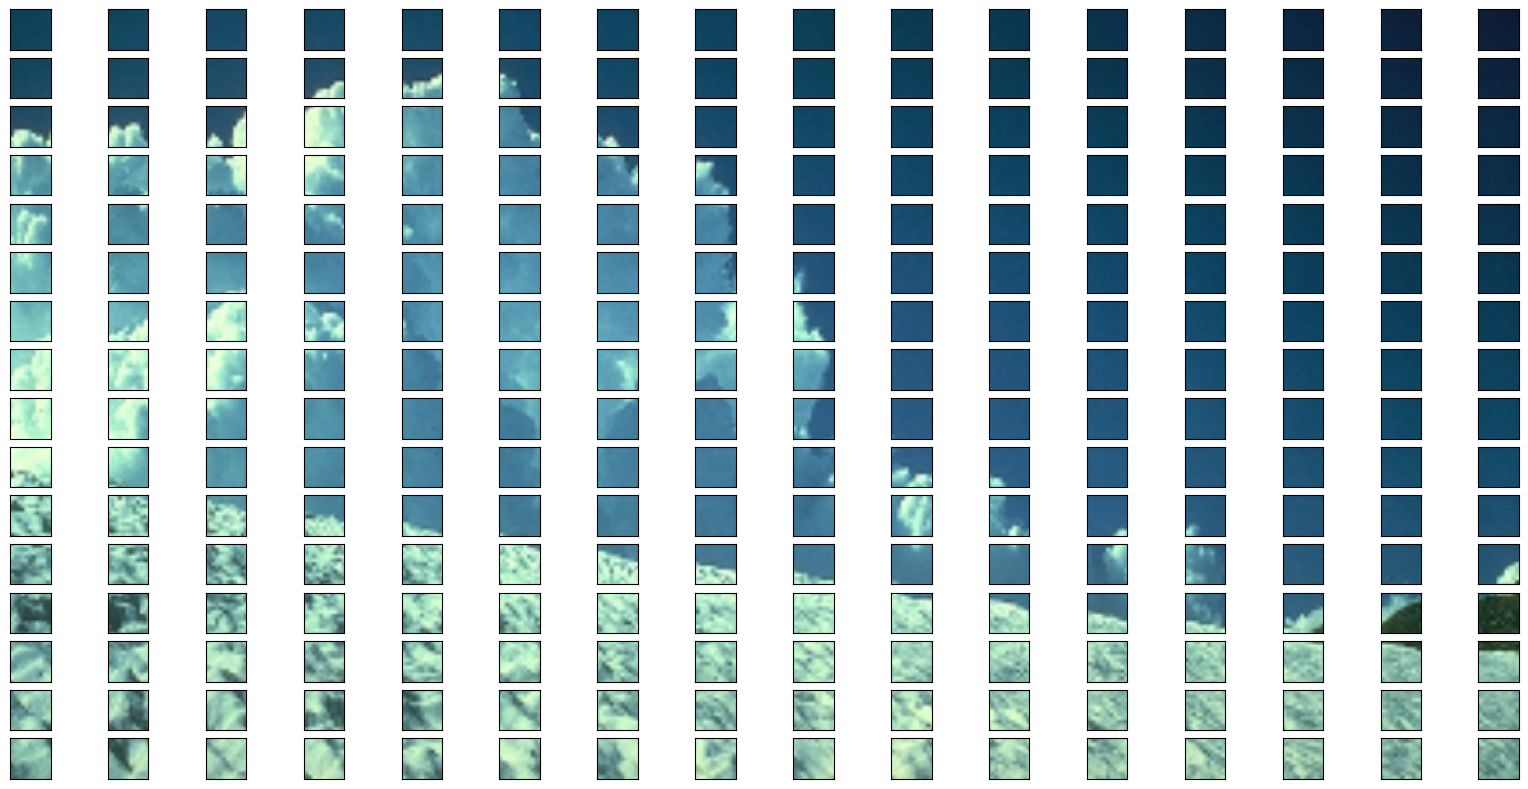

In [116]:
#display patches from ground truth image and noisy image
sample=df.sample(1)
for i in range(len(sample)):
  img = cv2.imread(sample['ground_truth'].iloc[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (512,512))
  patches_gt=patches(img,32)
  
  img = cv2.imread(sample['noisy'].iloc[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (512,512))
  patches_noisy=patches(img,32)

rows=patches_noisy.shape[0]
cols=patches_noisy.shape[1]
fig, axs = plt.subplots(rows,cols,figsize=(20,10))
for i in range(rows):
  for j in range(cols):
    axs[i][j].imshow(patches_gt[i][j][0])
    axs[i][j].get_xaxis().set_visible(False)
    axs[i][j].get_yaxis().set_visible(False)


### Create patches for X_train and y_train

In [117]:
X_train_patches = []
y_train_patches = []
for i in range(len(X_train)):
  path = X_train.iloc[i]
  img_nsy = cv2.imread(path)
  img_nsy = cv2.cvtColor(img_nsy, cv2.COLOR_BGR2RGB)
  
  img_nsy = cv2.resize(img_nsy,(256,256))  #resizing the X_train images
  patches_nsy = patches(img_nsy,32)
  
  path = y_train.iloc[i]
  img_gt = cv2.imread(path)
  img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
  img_gt = cv2.resize(img_gt,(256,256))  #resizing the y_train images
  patches_gt = patches(img_gt,32)

  rows = patches_nsy.shape[0]
  cols = patches_nsy.shape[1]
  for j in range(rows):
    for k in range(cols):
      X_train_patches.append(patches_nsy[j][k][0])
      y_train_patches.append(patches_gt[j][k][0])
  
X_train_patches = np.array(X_train_patches)
y_train_patches = np.array(y_train_patches)
print(X_train_patches.shape)
print(y_train_patches.shape)

(20480, 32, 32, 3)
(20480, 32, 32, 3)


### We have 20480 patches of 16X16X3 dimension for training data

In [118]:
#Creating patches for X_test and y_test
X_test_patches = []
y_test_patches = []
for i in range(len(X_test)):
  path = X_test.iloc[i]
  img_nsy = cv2.imread(path)
  img_nsy = cv2.cvtColor(img_nsy, cv2.COLOR_BGR2RGB)
  img_nsy = cv2.resize(img_nsy,(256,256))  #resizing the X_test images
  patches_nsy = patches(img_nsy,32)
  
  path = y_test.iloc[i]
  img_gt = cv2.imread(path)
  img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
  img_gt = cv2.resize(img_gt,(256,256))  #resizing the y_test images
  patches_gt = patches(img_gt,32)

  rows = patches_nsy.shape[0]
  cols = patches_nsy.shape[1]
  for j in range(rows):
    for k in range(cols):
      X_test_patches.append(patches_nsy[j][k][0])
      y_test_patches.append(patches_gt[j][k][0])

X_test_patches = np.array(X_test_patches)
y_test_patches = np.array(y_test_patches)

In [119]:
print(X_train_patches.shape)
print(y_train_patches.shape)
print(X_test_patches.shape)
print(y_test_patches.shape)
     

(20480, 32, 32, 3)
(20480, 32, 32, 3)
(5120, 32, 32, 3)
(5120, 32, 32, 3)


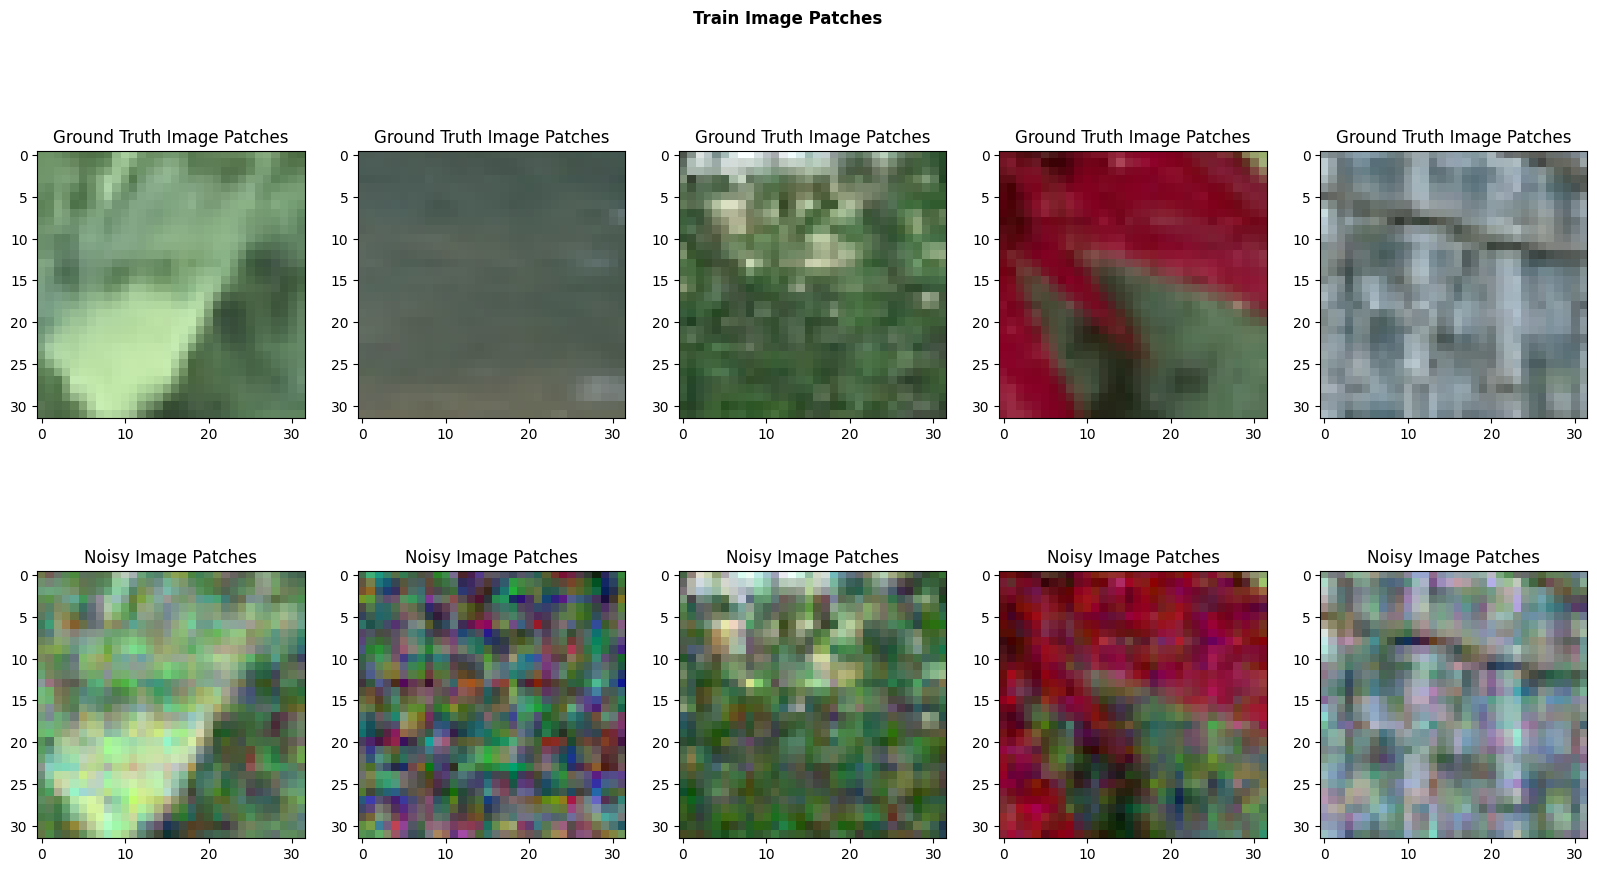

In [120]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
r = random.sample(range(0, len(X_train)), 5)

fig.suptitle('Train Image Patches',fontweight ="bold")
for i in range(5):
  axs[0][i].imshow(y_train_patches[r[i]])
  axs[0][i].set_title('Ground Truth Image Patches')
  axs[1][i].imshow(X_train_patches[r[i]])
  axs[1][i].set_title('Noisy Image Patches')

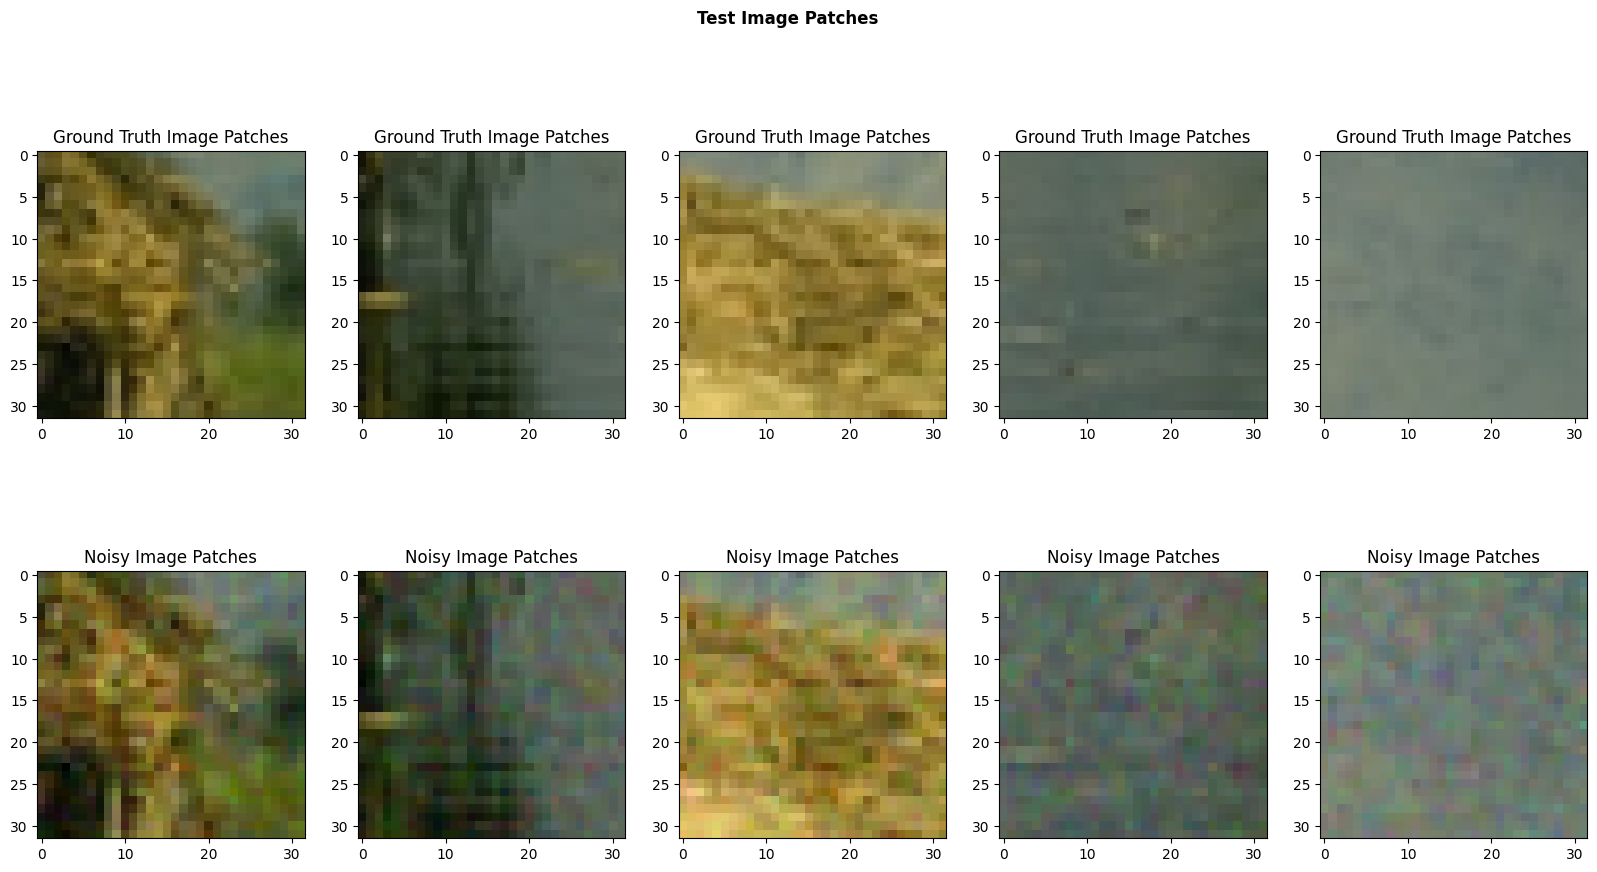

In [121]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
r = random.sample(range(0, len(X_test)), 5)

fig.suptitle('Test Image Patches',fontweight ="bold")
for i in range(5):
  axs[0][i].imshow(y_test_patches[r[i]])
  axs[0][i].set_title('Ground Truth Image Patches')
  axs[1][i].imshow(X_test_patches[r[i]])
  axs[1][i].set_title('Noisy Image Patches')

In [122]:

print("Total number of image patches on train data : ", (X_train_patches.shape))
print("Total number of image patches on test data : ", (X_test_patches.shape))

Total number of image patches on train data :  (20480, 32, 32, 3)
Total number of image patches on test data :  (5120, 32, 32, 3)


### Define the dataloader

In [123]:
#normalize the image patches
X_train_patches = X_train_patches.astype("float32") / 255.0
y_train_patches = y_train_patches.astype("float32") / 255.0
X_test_patches = X_test_patches.astype("float32") / 255.0
y_test_patches = y_test_patches.astype("float32") / 255.0

In [124]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, X,y,batch_size=1, shuffle=False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(X))

    def __getitem__(self, i):
        # collect batch data
        batch_x = self.X[i * self.batch_size : (i+1) * self.batch_size]
        batch_y = self.y[i * self.batch_size : (i+1) * self.batch_size]
        
        return tuple((batch_x,batch_y))
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [125]:
batch_size=32
train_dataloader = Dataloder(X_train_patches,y_train_patches, batch_size, shuffle=True)
test_dataloader = Dataloder(X_test_patches,y_test_patches,batch_size, shuffle=True)
print(train_dataloader[0][0].shape)

(32, 32, 32, 3)


## Autoencoder model

In [155]:
latent_dim=64
class Autoencoder(Model):
  def __init__(self,latent_dim):
    super(Autoencoder,self).__init__()
    self.latent_dim=latent_dim

    #encoder network
    self.encoder=Sequential([
        Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same',input_shape=(32,32,3),kernel_regularizer=None),
        MaxPooling2D((2,2),padding='same'),
        BatchNormalization(),
        Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same',kernel_regularizer=None),
        MaxPooling2D((2,2),padding='same'),
        BatchNormalization(),
        Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same',kernel_regularizer=None),
        MaxPooling2D((2,2),padding='same'),
        BatchNormalization()]
    )


    #decoder network
    self.decoder=Sequential([
        Conv2DTranspose(128,(3,3),strides=2,activation='relu',kernel_initializer='he_normal',padding='same'),
        Conv2DTranspose(64,(3,3),strides=2,activation='relu',kernel_initializer='he_normal',padding='same'),
        Conv2DTranspose(32,(3,3),strides=2,activation='relu',kernel_initializer='he_normal',padding='same'),
        Conv2D(3,(3,3),activation='sigmoid',kernel_initializer='he_normal',padding='same')
    ])

  def call(self,x):
    encoded=self.encoder(x)
    decoded=self.decoder(encoded)
    return decoded



In [156]:
auto_encoder=Autoencoder(latent_dim)
checkpoint_path = "training_1/cp.ckpt"
auto_encoder.compile(optimizer=optimizers.Adam(learning_rate=1e-3),loss=tf.keras.losses.MeanSquaredError())
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=True)

In [ ]:
#train 
history=auto_encoder.fit(X_train_patches,y_train_patches,
                 epochs=EPOCHS,
                 shuffle=True,
                 validation_data=(X_test_patches,y_test_patches),
                 callbacks=[model_checkpoint_callback])

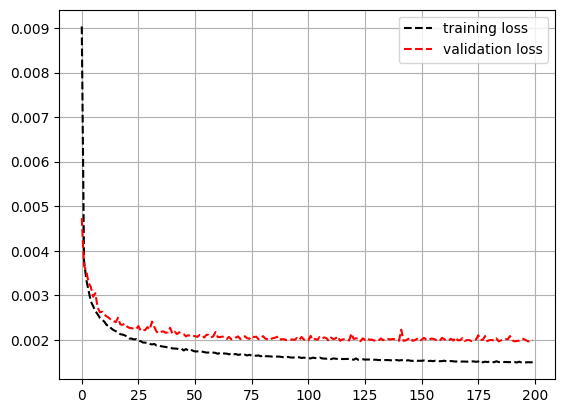

In [158]:
#plot the loss and accuracy plot
plt.plot(history.history['loss'],'k--')
plt.plot(history.history['val_loss'],'r--')
plt.legend(['training loss','validation loss'])
plt.grid()
plt.show()

### Visualize output of the model

In [159]:
#function to display multiple images in subplots
def display_images(list_of_images,list_of_titles=None):
    N=len(list_of_images)
    M=int(np.ceil(N/2))
    figs,ax=plt.subplots(M,2,figsize=(6,6))
    ax=ax.flatten()
    for i in range(len(list_of_images)):
        ax[i].imshow(list_of_images[i])
        if list_of_titles is not None:
            ax[i].title.set_text(list_of_titles[i])
    plt.show()

In [160]:
def predict(img,model,display=False,verbose=True):
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img=cv2.resize(img,(256,256))
  img=img.astype("float32")/255.0

  img_patches=patches(img,32)

  noisy_patches=[]
  for i in range(8):
    for j in range(8):
      noisy_patches.append(img_patches[i][j][0])
  noisy_patches=np.array(noisy_patches)

  pred_img=model.predict(noisy_patches,verbose=verbose)
  pred_img=np.reshape(pred_img,(8,8,1,32,32,3))
  pred_img=unpatchify(pred_img,img.shape)
  if display:
    display_images([img,pred_img])
  return pred_img


2/2 [==============================] - 1s 11ms/step


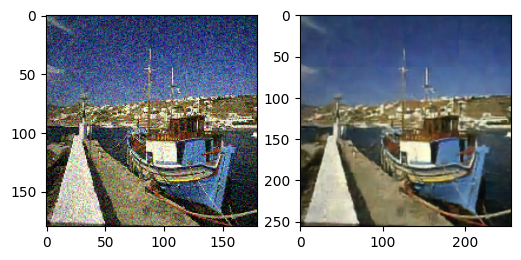

In [161]:
sample=df.sample(1)
img=cv2.imread(sample['noisy'].iloc[0])
img1=predict(img,auto_encoder)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
display_images([img,img1])

### calculate PSNR and SSIM 

In [162]:
def psnr_and_ssim(X_test,y_test,model,model_type='Normal',test_68=False):
  psnr_nsy = 0.0
  psnr_de_nsy = 0.0
  ssim_nsy = 0.0
  ssim_de_nsy = 0.0
  psnr_list=[]
  ssim_list=[]
  for i in range(len(X_test)):
    #getting the noisy images
    if test_68:
      path=X_test[i]
    else:
      path = X_test.iloc[i]
    nsy = cv2.imread(path)  


    pred = predict(nsy,model,verbose=False)

    #getting the ground truth images
    if test_68:
      path = y_test[i]
    else:
      path=y_test.iloc[i]
    gt = cv2.imread(path)         
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
    
    #Resizing the images
    gt = cv2.resize(gt,(256,256))
    nsy = cv2.resize(nsy,(256,256))

    #Normalizing the images
    gt = gt.astype("float32") / 255.0
    nsy = nsy.astype("float32") / 255.0

    #Computing psnr and ssim for test images
    psnr_list.append(PSNR(gt,pred))
    ssim_list.append(ssim(gt,pred,multichannel=True,data_range=pred.max()-pred.min()))
    psnr_nsy += PSNR(gt,nsy)
    psnr_de_nsy += PSNR(gt,pred)
    ssim_nsy += ssim(gt,nsy,multichannel=True,data_range=nsy.max() - nsy.min())
    ssim_de_nsy += ssim(gt,pred,multichannel=True,data_range=pred.max() - pred.min())

  psnr_nsy = psnr_nsy/len(X_test)
  psnr_de_nsy = psnr_de_nsy/len(X_test)
  ssim_nsy = ssim_nsy/len(X_test)
  ssim_de_nsy = ssim_de_nsy/len(X_test)
  return psnr_nsy, psnr_de_nsy,ssim_nsy,ssim_de_nsy,psnr_list,ssim_list

<ipython-input-162-398ab3315a45>:37: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_list.append(ssim(gt,pred,multichannel=True,data_range=pred.max()-pred.min()))
<ipython-input-162-398ab3315a45>:40: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_nsy += ssim(gt,nsy,multichannel=True,data_range=nsy.max() - nsy.min())
<ipython-input-162-398ab3315a45>:41: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_de_nsy += ssim(gt,pred,multichannel=True,data_range=pred.max() - pred.min())


PSNR before denoising : 53.75203533070908
PSNR after denoising : 59.402410274436235
SSIM before denoising : 0.4974015261977911
SSIM after denoising : 0.7798927284777164


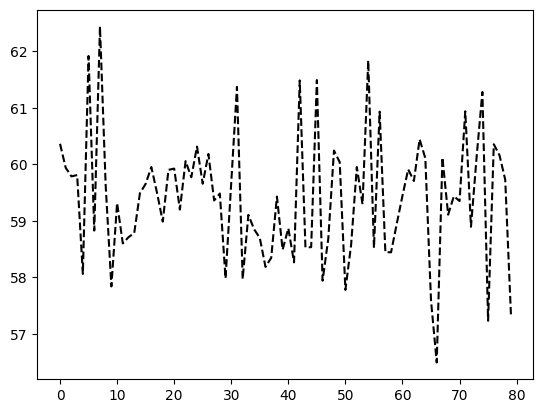

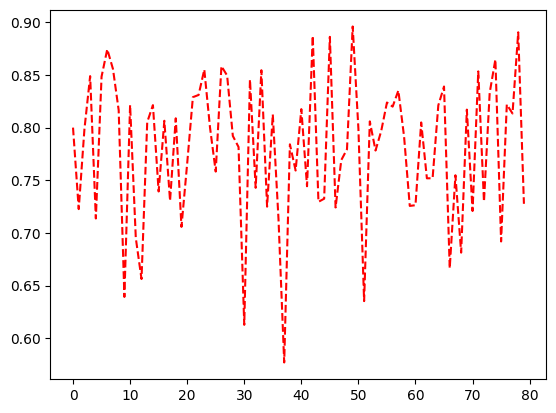

In [163]:

psnr_nsy, psnr_de_nsy, ssim_nsy, ssim_de_nsy,psnr_list,ssim_list = psnr_and_ssim(X_test,y_test,auto_encoder)
print('PSNR before denoising :', psnr_nsy)
print('PSNR after denoising :', psnr_de_nsy)
print('SSIM before denoising :', ssim_nsy)
print('SSIM after denoising :', ssim_de_nsy)
plt.plot(psnr_list,'k--')
plt.show()
plt.plot(ssim_list,'r--')
plt.show()

In [164]:
!zip -r checkpoint_autoencoder.zip /content/training_1

updating: content/training_1/ (stored 0%)
updating: content/training_1/cp.ckpt.data-00000-of-00001 (deflated 8%)
updating: content/training_1/cp.ckpt.index (deflated 69%)
updating: content/training_1/checkpoint (deflated 38%)


### Load from checkpoint and check

<ipython-input-162-398ab3315a45>:37: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_list.append(ssim(gt,pred,multichannel=True,data_range=pred.max()-pred.min()))
<ipython-input-162-398ab3315a45>:40: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_nsy += ssim(gt,nsy,multichannel=True,data_range=nsy.max() - nsy.min())
<ipython-input-162-398ab3315a45>:41: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_de_nsy += ssim(gt,pred,multichannel=True,data_range=pred.max() - pred.min())


PSNR before denoising : 53.75203533070908
PSNR after denoising : 59.51743282170374
SSIM before denoising : 0.4974015261977911
SSIM after denoising : 0.7842739678919315


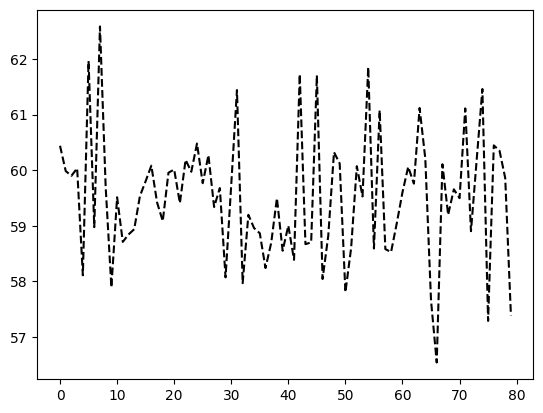

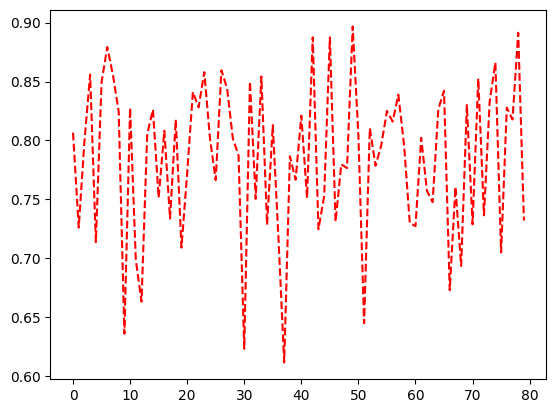

In [165]:
auto_encoder_1=Autoencoder(latent_dim)
auto_encoder_1.load_weights(checkpoint_path)
psnr_nsy, psnr_de_nsy, ssim_nsy, ssim_de_nsy,psnr_list,ssim_list = psnr_and_ssim(X_test,y_test,auto_encoder_1)
print('PSNR before denoising :', psnr_nsy)
print('PSNR after denoising :', psnr_de_nsy)
print('SSIM before denoising :', ssim_nsy)
print('SSIM after denoising :', ssim_de_nsy)
plt.plot(psnr_list,'k--')
plt.show()
plt.plot(ssim_list,'r--')
plt.show()

### check with set68 data

<ipython-input-162-398ab3315a45>:37: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_list.append(ssim(gt,pred,multichannel=True,data_range=pred.max()-pred.min()))
<ipython-input-162-398ab3315a45>:40: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_nsy += ssim(gt,nsy,multichannel=True,data_range=nsy.max() - nsy.min())
<ipython-input-162-398ab3315a45>:41: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_de_nsy += ssim(gt,pred,multichannel=True,data_range=pred.max() - pred.min())


PSNR before denoising : 54.58757687131089
PSNR after denoising --> mean:59.0193, variance:1.5265
SSIM before denoising : 0.6564195782822722
SSIM after denoising --> mean:0.7632, variance:0.0719


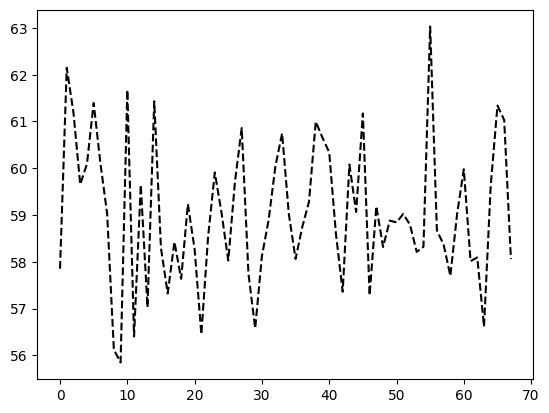

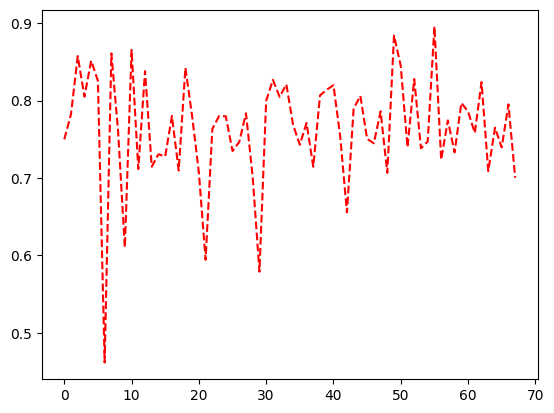

In [168]:

test_set_path='/content/drive/MyDrive/EE6310_course_project/noisy15/*.png'
original_file_path='/content/drive/MyDrive/EE6310_course_project/original_png/'
file_names=glob(test_set_path)
X_test_68=[]
y_test_68=[]
for file in file_names:
  input_name=file.split('/')[-1]
  X_test_68.append(file)
  y_test_68.append(original_file_path+input_name)

psnr_nsy, psnr_de_nsy, ssim_nsy, ssim_de_nsy,psnr_list,ssim_list = psnr_and_ssim(X_test_68,y_test_68,auto_encoder_1,test_68=True)
print('PSNR before denoising :', psnr_nsy)
print('PSNR after denoising --> mean:{:.4f}, variance:{:.4f}'.format(np.mean(psnr_list),np.std(psnr_list)))
print('SSIM before denoising :', ssim_nsy)
print('SSIM after denoising --> mean:{:.4f}, variance:{:.4f}'.format(np.mean(ssim_list),np.std(ssim_list)))

plt.plot(psnr_list,'k--')
plt.show()
plt.plot(ssim_list,'r--')
plt.show()

<ipython-input-162-398ab3315a45>:37: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_list.append(ssim(gt,pred,multichannel=True,data_range=pred.max()-pred.min()))
<ipython-input-162-398ab3315a45>:40: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_nsy += ssim(gt,nsy,multichannel=True,data_range=nsy.max() - nsy.min())
<ipython-input-162-398ab3315a45>:41: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_de_nsy += ssim(gt,pred,multichannel=True,data_range=pred.max() - pred.min())


PSNR before denoising : 54.22167761824318
PSNR after denoising --> mean:58.7513, variance:1.4061
SSIM before denoising : 0.5165209185112926
SSIM after denoising --> mean:0.7278, variance:0.0751


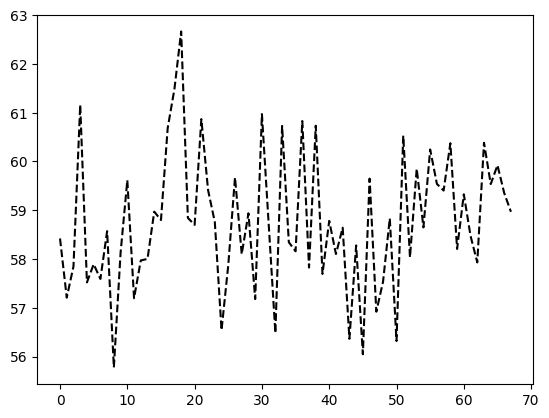

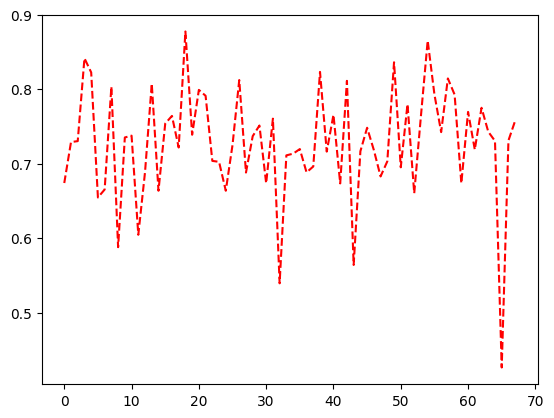

In [167]:

test_set_path='/content/drive/MyDrive/EE6310_course_project/noisy25/*.png'
original_file_path='/content/drive/MyDrive/EE6310_course_project/original_png/'
file_names=glob(test_set_path)
X_test_68=[]
y_test_68=[]
for file in file_names:
  input_name=file.split('/')[-1]
  X_test_68.append(file)
  y_test_68.append(original_file_path+input_name)

psnr_nsy, psnr_de_nsy, ssim_nsy, ssim_de_nsy,psnr_list,ssim_list = psnr_and_ssim(X_test_68,y_test_68,auto_encoder_1,test_68=True)
print('PSNR before denoising :', psnr_nsy)
print('PSNR after denoising --> mean:{:.4f}, variance:{:.4f}'.format(np.mean(psnr_list),np.std(psnr_list)))
print('SSIM before denoising :', ssim_nsy)
print('SSIM after denoising --> mean:{:.4f}, variance:{:.4f}'.format(np.mean(ssim_list),np.std(ssim_list)))
plt.plot(psnr_list,'k--')
plt.show()
plt.plot(ssim_list,'r--')
plt.show()